# Constraint-based algorithm: PC

In [9]:
import pandas as pd
df = pd.read_stata("data/close_college.dta")
display(df.head())

,nearc4,educ,black,smsa,south,married,exper,lwage
0,0,7,1,1,0,1.0,16,6.306275
1,0,12,0,1,0,1.0,9,6.175867
2,0,12,0,1,0,1.0,16,6.580639
3,1,11,0,1,0,1.0,10,5.521461
4,1,12,0,1,0,1.0,16,6.591674


In [2]:
import os
os.environ['R_HOME'] = "C:/PROGRA~1/R/R-43~1.1" # PATH FEMKE

%load_ext rpy2.ipython

c:\Users\femke\anaconda3\envs\causal_data_science_env\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
# import necessary packages
from itertools import combinations

import cdt
# cdt.SETTINGS.rpath = '/usr/local/bin/Rscript' # for macOS
# cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.0.3/bin/Rscript' # for Windows
cdt.SETTINGS.rpath = 'C:/PROGRA~1/R/R-43~1.1/bin/Rscript' # for FEMKE PATH



#from dowhy import CausalModel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy.random import normal
import pandas as pd
import pingouin as pg

np.random.seed(0)

c:\Users\femke\anaconda3\envs\causal_data_science_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.


### Functions

In [4]:
def get_positions(input_df):
    x =  [0, 1, 1, 0, -1, -1, 0.5, -0.5]
    y =  [1, 0.5, -0.5, -1, -0.5, 0.5, 0, 0]
    x = [i*4 for i in x]
    y = [i*4 for i in y]

    pos = dict()
    for i in range(len(input_df.columns)):
        node = list(input_df.columns.values)[i]
        pos[node] = (x[i], y[i])

    return pos

pos = get_positions(df)
print(pos)

{'nearc4': (0, 4), 'educ': (4, 2.0), 'black': (4, -2.0), 'smsa': (0, -4), 'south': (-4, -2.0), 'married': (-4, 2.0), 'exper': (2.0, 0), 'lwage': (-2.0, 0)}


In [5]:
def compare_edges(G1, G2):
    items_not_in_list2 = [item for item in G1.edges() if item not in G2.edges()]
    items_not_in_list1 = [item for item in G2.edges() if item not in G1.edges()]

    print("Items in -G1- not present in -G2- :")
    print(items_not_in_list2)
    print("\nItems in -G2- not present in -G1- :")
    print(items_not_in_list1)

### Guassian

Without prior knowledge

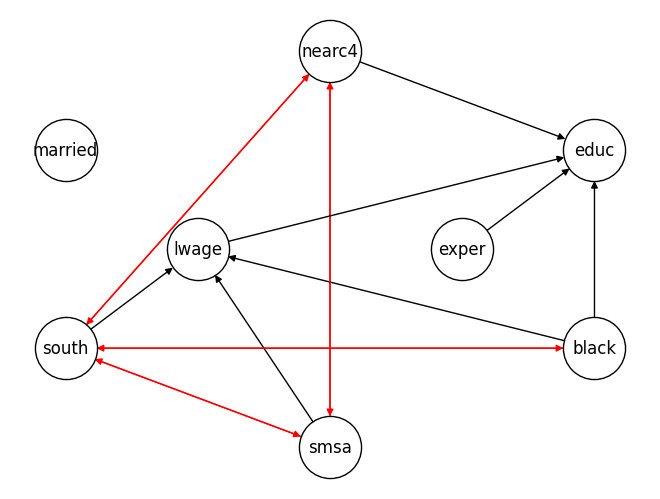

In [6]:
alpha = 0.05
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)
pc_graph_gaus = pc.create_graph_from_data(df)


colors = ['red'  if (y,x) in pc_graph_gaus.edges() else 'black' for (x,y) in pc_graph_gaus.edges()]
nx.draw(pc_graph_gaus, with_labels=True, node_size=2000, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

With prior knowledge:
- edge between lwage and exper
- edge between lwage and educ

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


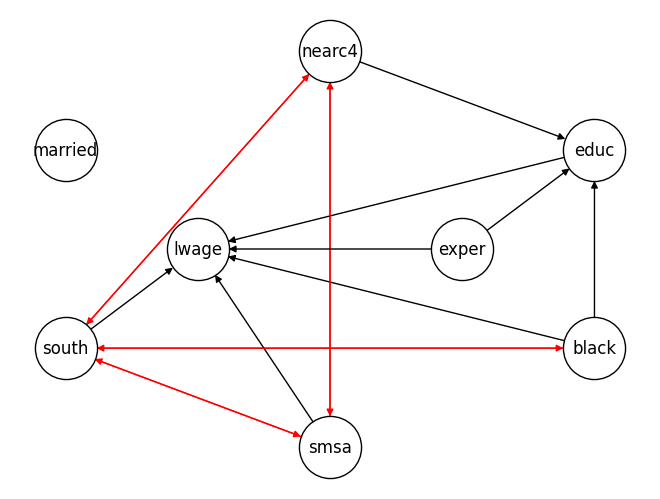

In [12]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)


### Define background knowledge ###
prior_graph = nx.DiGraph() # Create a graph to hold our background knowledge
prior_graph.add_nodes_from(df.columns) # Add nodes
prior_graph.add_edges_from([('exper', 'lwage'), ('lwage', 'exper')]) 
prior_graph.add_edges_from([('lwage', 'educ'), ('educ', 'lwage')]) 

fixed_edges = pd.DataFrame(nx.adjacency_matrix(prior_graph).todense()) # Symmetric adjacency matrix representing edges that exist
fixed_gaps = pd.DataFrame(np.zeros((8,8), dtype=int)) # Symmetric adjacency matrix representing edges that canNOT exist


### Run PC ###
pc.arguments['{CITEST}'] = pc.dir_CI_test[pc.CI_test]
pc.arguments['{METHOD_INDEP}'] = pc.dir_method_indep[pc.CI_test]
pc.arguments['{DIRECTED}'] = 'TRUE'
pc.arguments['{ALPHA}'] = str(pc.alpha)
pc.arguments['{NJOBS}'] = str(pc.njobs)
result = pc._run_pc(df, fixedEdges=fixed_edges, fixedGaps=fixed_gaps)
pc_graph_gaus_pk = nx.relabel_nodes(nx.DiGraph(result), {idx: i for idx, i in enumerate(df.columns)})

### Visalise ###
colors = ['red'  if (y,x) in pc_graph_gaus_pk.edges() else 'black' for (x,y) in pc_graph_gaus_pk.edges()]
nx.draw(pc_graph_gaus_pk, with_labels=True, node_size=2000, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

Check if without prior knowlegde has the same edges as with prior knowledge:

In [13]:
print(pc_graph_gaus.edges() == pc_graph_gaus_pk.edges())
compare_edges(pc_graph_gaus,pc_graph_gaus_pk)

False
Items in -G1- not present in -G2- :
[('lwage', 'educ')]

Items in -G2- not present in -G1- :
[('educ', 'lwage'), ('exper', 'lwage')]
